# HEWL S-SAD Merging Statistics

Merging statistics are a useful means to assess data quality in crystallography. However, each statistic has inherent shortcomings. For example, R-merge will appear inflated if the multiplicity is high, and the Pearson correlation coefficients used for $CC_{1/2}$ are very sensitive to outliers. 

Most scaling and merging programs output multiple merging statistics to get around these shortcomings. However, one can imagine that it could also be useful to customize certain parameters, such as how many resolution bins are used. Or, perhaps a better statistic will be developed that is worth implementing. 

In this notebook, ``reciprocalspaceship`` is used to compute half-dataset correlation coefficients ($CC_{1/2}$ and $CC_{anom}$) for a dataset collected from a tetragonal hen egg-white lysozyme (HEWL) crystal at 6550 eV. 
These data are unmerged, but were scaled in AIMLESS. 
They contain sufficient sulfur anomalous signal to determine a solution by the SAD method. 
This illustrates the use of ``rs`` to implement a merging routine, create a custom analysis, and could be useful as a template for other exploratory crystallographic data analyses. 
As an example, we will compare half-dataset correlations computed using both Pearson and Spearman correlation coefficients.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("notebook", font_scale=1.3)
import numpy as np

In [2]:
import reciprocalspaceship as rs

In [3]:
print(rs.__version__)

0.9.9


---
### Load scaled, unmerged data  

This data has been scaled in AIMLESS. The data includes the image number and the scaled **I** and **SIGI** values. 

In [4]:
hewl = rs.read_mtz("data/HEWL_unmerged.mtz")

In [5]:
hewl.head()

BATCH         I      SIGI  PARTIAL
H K L                                    
0 0 4    137  696.5212  87.83294    False
    4    520  710.6812 88.107025    False
    4    856 672.05634  87.75671    False
    4   1239 642.47485  87.90302    False
    4   2160 655.71783  87.74394    False

In [6]:
print(f"Number of observed reflections: {len(hewl)}")

Number of observed reflections: 816804


---
### Merging with Inverse-Variance Weights

Since the input data are unmerged, we will implement the inverse-variance weighting scheme used by AIMLESS to merge the observations. 
The weighted average is a better estimator of the true mean than the raw average, and this weighting scheme corresponds to the maximum likelihood estimator of the true mean if we assume that the observations are normally-distributed about the true mean. 

The merged intensity for each reflection, $I_h$, can be determined from the observed intensities, $I_{h,i}$, and error estimates, $\sigma_{h,i}$, as follows:

\begin{equation}
I_h = \frac{\sum_{i}w_{h,i} I_{h,i}}{\sum_{i} w_{h,i}}
\end{equation}

where the weight for each observation, $w_{h,i}$ is given by:

\begin{equation}
w_{h,i} = \frac{1}{(\sigma_{h,i})^2}
\end{equation}

The updated estimate of the uncertainty, $\sigma_{h}$, is given by:

\begin{equation}
\sigma_{h} = \sqrt{\frac{1}{\sum_{i} w_{h,i}}}
\end{equation}

Let's start by implementing the above equations in a function that will compute the merged $I_h$ and $\sigma_h$. We will use the [Pandas groupby](https://pandas.pydata.org/pandas-docs/stable/user_guide/groupby.html) methods to apply this function across the unique Miller indices in the ``DataSet``. If we group Friedel pairs together, we will refer to the quantity as **IMEAN**, and if we keep the Friedel pairs separate we will refer to the quantities as **I(+)**  and **I(-)**.

In [7]:
def merge(dataset, anomalous=False):
    """
    Merge dataset using inverse-variance weights.
    
    Parameters
    ----------
    dataset : rs.DataSet
        DataSet to be merged containing scaled I and SIGI
    anomalous : bool
        If True, I(+) and I(-) will be reported. If False,
        IMEAN will be reported
        
    Returns
    -------
    rs.DataSet
        Merged DataSet object
    """
    ds = dataset.hkl_to_asu(anomalous=anomalous)
    ds["w"]  = ds['SIGI']**-2
    ds["wI"] = ds["I"] * ds["w"]
    g = ds.groupby(["H", "K", "L"])
    
    result = g[["w", "wI"]].sum()
    result["I"] = result["wI"] / result["w"]
    result["SIGI"] = np.sqrt(1 / result["w"])
    result = result.loc[:, ["I", "SIGI"]]
    result.merged = True
    
    if anomalous:
        result = result.unstack_anomalous()
    
    return result

Using `anomalous=False`, this function can be used to compute **IMEAN** and **SIGIMEAN** by including both Friedel pairs:

In [8]:
result1 = merge(hewl, anomalous=False)

In [9]:
result1.sample(5)

,,,I,SIGI
H,K,L,,
23,22,9,1349.8007,22.878157
37,19,0,260.0996,9.075029
17,11,15,146.02324,2.895325
35,1,14,9.629998,3.902024
15,5,18,7.837115,1.039951


Using `anomalous=True`, this function can be used to compute **I(+)**, **SIGI(+)**, **I(-)**, and **SIGI(-)** by separating Friedel pairs:

In [10]:
result2 = merge(hewl, anomalous=True)

In [11]:
result2.sample(5)

,,,I(+),SIGI(+),SIGI(-),I(-)
H,K,L,,,,
20,4,7,790.00696,13.43943,13.45224,819.43054
21,15,16,51.543583,2.840802,2.675156,50.629883
35,8,12,56.64869,2.762924,2.779431,52.87201
16,16,15,517.4729,11.513449,11.513449,517.4729
33,23,3,101.954094,3.753756,3.605523,89.131714


A variant of the above function is implemented in `rs.algorithms`, and we will use that implementation in the next section for computing merging statistics. This function computes **IMEAN**, **I(+)**, **I(-)**, and associated uncertainties for each unique Miller index.

In [12]:
result3 = rs.algorithms.merge(hewl)

In [13]:
result3.sample(5)

,,,IMEAN,SIGIMEAN,I(+),SIGI(+),I(-),SIGI(-),N(+),N(-)
H,K,L,,,,,,,,
38,10,4,454.0382,11.617793,416.8525,21.370535,469.6386,13.841894,8,20
17,9,15,101.308815,2.1820927,100.45327,3.0412343,102.21658,3.1326878,32,31
38,7,8,4.571434,0.9255639,4.8481956,1.2750458,4.2631493,1.3457003,20,20
11,5,5,3991.629,47.690647,4061.3477,66.316765,3916.9563,68.63234,60,56
27,18,11,14.8991,1.0327507,10.999734,1.4392322,19.038132,1.4828024,20,20


---
### Merging with 2-fold Cross-Validation  

To compute correlation coefficients we will repeatedly split our data into half-datasets. We will do this by randomly splitting the data using the image number. These half-datasets will be merged independently and used to determine uncertainties in the correlation coefficients. We will first write a method to randomly split our data, and then we will then write a method that automates the sampling and merging of multiple half-datasets. 

In [14]:
def sample_halfdatasets(data):
    """Randomly split DataSet into two equal halves by BATCH"""
    batch = data.BATCH.unique().to_numpy(dtype=int)
    np.random.shuffle(batch)
    halfbatch1, halfbatch2 = np.array_split(batch, 2)
    half1 = data.loc[data.BATCH.isin(halfbatch1)]
    half2 = data.loc[data.BATCH.isin(halfbatch2)]
    return half1, half2

In [15]:
def merge_dataset(dataset, nsamples):
    """
    Merge DataSet using inverse-variance weighting scheme. This represents the 
    maximum-likelihood estimator of the mean of the observed intensities assuming 
    they are independent and normally distributed with the same mean. 
    
    Sample means across half-datasets can be used to compute the merging statistics CC1/2 and CCanom.
    """
    dataset = dataset.copy()
    samples = []
    for n in range(nsamples):
        half1, half2 = sample_halfdatasets(dataset)
        mergedhalf1 = rs.algorithms.merge(half1)
        mergedhalf2 = rs.algorithms.merge(half2)
        result = mergedhalf1.merge(mergedhalf2, left_index=True, right_index=True, suffixes=(1, 2))
        result["sample"] = n
        samples.append(result)
    return rs.concat(samples).sort_index()

---
### Merge HEWL data

We will now merge the HEWL data, repeatedly sampling across half-datasets in order to assess the distribution of correlation coefficients.

In [16]:
# This cell takes a few minutes with nsamples=15
merged = merge_dataset(hewl, 15)

In [17]:
merged

IMEAN1  SIGIMEAN1     I(+)1  SIGI(+)1     I(-)1  SIGI(-)1  N(+)1  \
H  K  L                                                                       
0  0  4 657.99817  43.882294 657.99817 43.882294 657.99817 43.882294      4   
      4 645.79663  43.884262 645.79663 43.884266 645.79663 43.884266      4   
      4  662.0198  25.348951  662.0198 25.348951  662.0198 25.348951     12   
      4  660.4694   33.18889  660.4694  33.18889  660.4694  33.18889      7   
      4  666.3023  24.359608  666.3023  24.35961  666.3023  24.35961     13   
...           ...        ...       ...       ...       ...       ...    ...   
45 10 2 30.170218  7.3511124 30.170218 7.3511124       NaN       NaN      1   
      2  7.669444  6.6297607  7.669444 6.6297607       NaN       NaN      1   
      2 11.665072  5.2794247 11.665072 5.2794247       NaN       NaN      2   
      2  7.669444  6.6297607  7.669444 6.6297607       NaN       NaN      1   
      2 17.961912   4.288131 17.961912  4.288131       NaN       NaN      3   

         N(-)1    IMEAN2  SIGIMEAN2     I(+)2  SIGI(+)2     I(-)2  SIGI(-)2  \
H  K  L                                                                       
0  0  4      4 662.40204   25.35386 662.40204 25.353859 662.40204 25.353859   
      4      4  666.4745   25.35348  666.4745  25.35348  666.4745  25.35348   
      4     12 659.13995  43.907776 659.13995 43.907776 659.13995 43.907776   
      4      7   661.946  29.271538   661.946 29.271538   661.946 29.271538   
      4     13 639.66833  50.654987 639.66833 50.654987 639.66833 50.654987   
...        ...       ...        ...       ...       ...       ...       ...   
45 10 2      0 15.318142  3.9687188 15.318142 3.9687188       NaN       NaN   
      2      0  22.89468  4.1084785  22.89468 4.1084785       NaN       NaN   
      2      0 24.119883   4.656634 24.119883  4.656634       NaN       NaN   
      2      0  22.89468  4.1084785  22.89468 4.1084785       NaN       NaN   
      2      0 20.064919  6.0180674 20.064919 6.0180674       NaN       NaN   

         N(+)2  N(-)2  sample  
H  K  L                        
0  0  4     12     12       0  
      4     12     12       1  
      4      4      4       2  
      4      9      9       3  
      4      3      3       4  
...        ...    ...     ...  
45 10 2      3      0       9  
      2      3      0      10  
      2      2      0      11  
      2      3      0      12  
      2      1      0      13  

[187364 rows x 17 columns]

---
### Compute $CC_{1/2}$ and $CC_{anom}$  

We will first assign each reflection to a resolution bin and then we will compute the correlation coefficients

In [18]:
merged, labels = merged.assign_resolution_bins(bins=15)

In [19]:
groupby1 = merged.groupby(["sample", "bin"])[["IMEAN1", "IMEAN2"]]
pearson1 = groupby1.corr(method="pearson").unstack().loc[:, ("IMEAN1", "IMEAN2")]
pearson1.name = "Pearson"
spearman1 = groupby1.corr(method="spearman").unstack().loc[:, ("IMEAN1", "IMEAN2")]
spearman1.name = "Spearman"
results1 = rs.concat([pearson1, spearman1], axis=1)
results1 = results1.groupby("bin").agg(["mean", "std"])

In [20]:
results1.head()

Pearson            Spearman          
         mean       std      mean       std
bin                                        
0    0.997334  0.000316  0.998895  0.000063
1    0.997958  0.000360  0.999363  0.000066
2    0.998971  0.000306  0.999678  0.000023
3    0.999297  0.000102  0.999658  0.000024
4    0.999368  0.000147  0.999687  0.000022

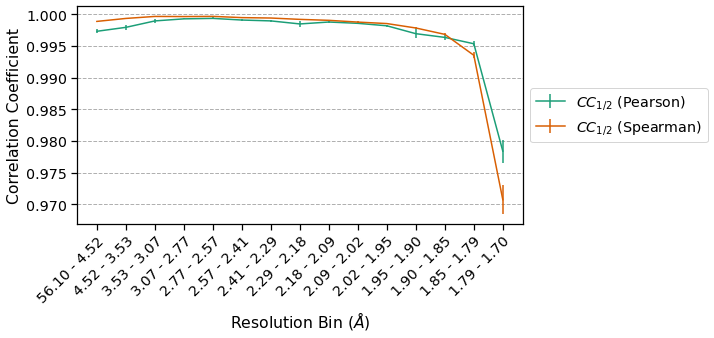

In [21]:
plt.figure(figsize=(8, 4))
plt.errorbar(results1.index, results1[("Pearson", "mean")], 
             yerr=results1[("Pearson", "std")], 
             color="#1b9e77", 
             label=r"$CC_{1/2}$ (Pearson)")
plt.errorbar(results1.index, results1[("Spearman", "mean")], 
             yerr=results1[("Spearman", "std")], 
             color="#d95f02", 
             label=r"$CC_{1/2}$ (Spearman)")
plt.xticks(results1.index, labels, rotation=45, ha='right', rotation_mode='anchor')
plt.ylabel("Correlation Coefficient")
plt.xlabel(r"Resolution Bin ($\AA$)")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(axis="y", linestyle='--')
plt.show()

It is important to note the scale on the y-axis -- this dataset is edge-limited, and as such the $CC_{1/2}$ is very high across all resolution bins. The Spearman CC appears higher across all resolution bins except at high resolution, and overall has a lower standard deviation among samples.
This is consistent with our expectation that Spearman CCs are a more robust estimator of correlation than Pearson CCs.

Let's now repeat this for the anomalous data, computing $CC_{anom}$:

In [22]:
merged["ANOM1"] = merged["I(+)1"] - merged["I(-)1"]
merged["ANOM2"] = merged["I(+)2"] - merged["I(-)2"]

# Similar to CChalf, but we will only look at acentric reflections
groupby2 = merged.acentrics.groupby(["sample", "bin"])[["ANOM1", "ANOM2"]]
pearson2 = groupby2.corr(method="pearson").unstack().loc[:, ("ANOM1", "ANOM2")]
pearson2.name = "Pearson"
spearman2 = groupby2.corr(method="spearman").unstack().loc[:, ("ANOM1", "ANOM2")]
spearman2.name = "Spearman"
results2 = rs.concat([pearson2, spearman2], axis=1)
results2 = results2.groupby("bin").agg(["mean", "std"])

In [23]:
results2.head()

Pearson            Spearman          
         mean       std      mean       std
bin                                        
0    0.422196  0.037998  0.497923  0.029704
1    0.233349  0.061975  0.328263  0.023917
2    0.357182  0.051746  0.444657  0.029250
3    0.484710  0.045454  0.543314  0.031731
4    0.579058  0.023952  0.611739  0.020141

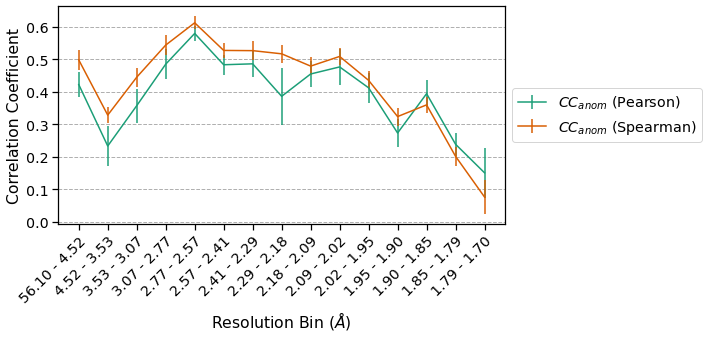

In [24]:
plt.figure(figsize=(8, 4))
plt.errorbar(results2.index, results2[("Pearson", "mean")], 
             yerr=results2[("Pearson", "std")], 
             color="#1b9e77", 
             label=r"$CC_{anom}$ (Pearson)")
plt.errorbar(results2.index, results2[("Spearman", "mean")],
             yerr=results2[("Spearman", "std")], 
             color="#d95f02", 
             label=r"$CC_{anom}$ (Spearman)")
plt.xticks(results2.index, labels, rotation=45, ha='right', rotation_mode='anchor')
plt.ylabel("Correlation Coefficient")
plt.xlabel(r"Resolution Bin ($\AA$)")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(axis="y", linestyle='--')
plt.show()

There is significant anomalous signal across all but the highest resolution bins. The Spearman CCs have smaller error bars than the corresponding Pearson CCs and the Spearman CCs are also higher in most bins. These differences highlight the influence of outlier measurements on the different correlation coefficients.

---
### Summary  

We have used `reciprocalspaceship` to merge a dataset using inverse-variance weights. As part of this analysis, we performed repeated 2-fold cross-validation to compute Pearson and Spearman correlation coefficients and associated uncertainties. This relatively simple procedure to obtain uncertainty estimates for correlation coefficients is seldom done when analyzing merging quality. However, we can see that the standard deviation for computed correlation coefficients can be nearly $\pm0.1$ for quantities such as $CC_{anom}$. This is worth keeping in mind when analyzing SAD experiments because this dataset is very high quality (edge-limited) when one considers the $CC_{1/2}$. Putting these two correlation coefficients on the same axes emphasizes this point:

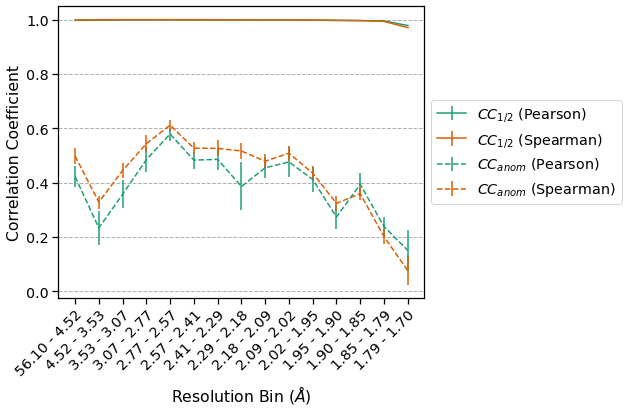

In [25]:
plt.figure(figsize=(9, 6))
plt.errorbar(results1.index, results1[("Pearson", "mean")], 
             yerr=results1[("Pearson", "std")], 
             color='#1b9e77', 
             label=r"$CC_{1/2}$ (Pearson)")
plt.errorbar(results1.index, results1[("Spearman", "mean")], 
             yerr=results1[("Spearman", "std")], 
             color='#d95f02', 
             label=r"$CC_{1/2}$ (Spearman)")
plt.errorbar(results2.index, results2[("Pearson", "mean")], 
             yerr=results2[("Pearson", "std")], 
             color='#1b9e77', 
             linestyle="--", 
             label=r"$CC_{anom}$ (Pearson)")
plt.errorbar(results2.index, results2[("Spearman", "mean")], 
             yerr=results2[("Spearman", "std")], 
             color='#d95f02', 
             linestyle="--", 
             label=r"$CC_{anom}$ (Spearman)")
plt.xticks(results1.index, labels, rotation=45, ha='right', rotation_mode='anchor')
plt.ylabel(r"Correlation Coefficient")
plt.xlabel(r"Resolution Bin ($\AA$)")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(axis="y", linestyle='--')
plt.tight_layout()

Even a simple change to the procedure for computing merging statistics, such as substituting a Spearman correlation coefficient for a Pearson one, can alter the apparent quality of a dataset. By lowering the barrier to implementing new analyses, we hope that `reciprocalspaceship` can encourage the development of more robust indicators of crystallographic data quality.